# Lab: Intro to Spatial Modeling with Patches
#### Jessie Conrad, MSPH
#### MIDAS-CCDD Outreach Session: Spatial methods and risk assessments

## Part 1: Deterministic SIR Model Review
The SIR model as we know it today was first formalized by Kermack and McKendrick in 1927. This mass-action compartmental model aims to predict the transmission of disease through a susceptible population over time. While the original model was a partial differential equaiton system tracking age-of-infection, we will explore here the simplified model that is only a function of time.

The basic model is as follows:
$$
\begin{align}
\frac{dS}{dt} & = -\beta S \frac{I}{N} \\
\frac{dI}{dt} & = \beta S \frac{I}{N} - \gamma I \\
\frac{dR}{dt} & = \gamma I,
\end{align}
$$
where *t* is time, *S(t)* is susceptible people, *I(t)* is infected people, and *R(t)* is removed (aka recovered and/or dead) people. *$\beta$* is the infection rate, and *$\gamma$* is the recovery rate.
<div class="alert alert-block alert-info">
<b>Note:</b> S + I + R = N implies a constant population. Our model assumes no birth or death explicitly.
</div>

For this model, we can define the basic reproductive number, $\mathcal{R}_0$:
$$
\mathcal{R}_0 = \frac{\beta}{\gamma},
$$
where we can consider $\frac{1}{\gamma}$ as the average time spent in the infectious compartment *I(t)*. As such, $\mathcal{R}_0$ is the average number of secondary infections from the introduction of a single infectious case into a completely susceptible population. $\mathcal{R}_0$ can be used as a rough estimate of the risk of an outbreak: if $\mathcal{R}_0 > 1$, we expect an epidemic to grow; else if $\mathcal{R}_0 < 1$, we expect the epidemic to die out.

To summarize, our important variables and definitions are:
* **N** : total population
* **S(t)** : susceptible population at time *t*
* **I(t)** : infected population at time *t*
* **R(t)** : removed population at time *t*
* __$\beta$__ : infection rate; expected number of secondary infections per time *t*
* __$\gamma$__ : recovery rate; $\frac{1}{\gamma}$ is average time a person is infected for
* __$\mathcal{R}_0$__ : average number of secondary infections from one person per time *t*

<div class="alert alert-block alert-info">
<b>Note:</b> $\mathcal{R}_0$ as we have defined it above is only valid for a short time at the initialization of the epidemic. The effective reproductive number $\mathcal{R}_t$ should be used for risk calculations after time $t=0$. This can be approximated as $\mathcal{R}_t= \mathcal{R}_0 \frac{S(t)}{N} = \frac{\beta}{\gamma} \frac{S(t)}{N}$.
</div>


### Optional Resources
If you have never coded in Python before, the following short tutorials are recommended:
* [10 minute Python Tutorial](https://www.stavros.io/tutorials/python/) Short tutorial with the basics recommended if you have done coding before in Python, but maybe not in a while
* [Official Python Tutorial](https://docs.python.org/3/tutorial/) Official python tutorial with details and references. Good if you have never coded in Python before.
* [Think Python](https://greenteapress.com/wp/think-python-2e/) In depth introduction to Python coding

### Coding the deterministic SIR Model
Now let's review how to code the deterministic SIR Model in Python. We will write this code together, step by step, then put it together! 

First, we will import the libraries we will need for this code:

In [73]:
from math import *                  # useful math functions
import numpy as np                  # useful array objects 
                                    # (also a core scientific computing library)
import matplotlib.pyplot as plt     # nice plotting commands
from scipy.integrate import odeint  # ode solver

Now let's try defining funcitons for movement between compartments! Fill in the state equations below:


In [74]:
def sir_model(x, t, N, beta, gamma):
    #Basic SIR Model
    
    ###########################
    #Input:
    #   x                   array of state variables S, I, R
    #   t                   vector of time inputs
    #   N                   total population
    #   beta                infection rate
    #   gamma               recovery rate
    #Output:
    #   dS, dI, DR          derivatives of state variables
    ###########################
    
    S, I, R = x
    dS = -beta * S *I/N
    dI = beta * S *I/N - gamma * I
    dR = gamma * I
    
    return dS, dI, dR

Now let's assume we have a population of 1000, with an average infection rate of 1 people per day, who recover over the course of 4 days. We will have a single infected individual at time 0 and run our simulation for 50 time steps. We can define our inital parameters then as follows:

In [75]:
N = 1000
beta = 1.0                  #an infected person infects 1 other people per day
gamma = 1.0 / 4.0           #average infection time of 4 days

R0 = beta / gamma             #Check that R0 is greater than 1 and therefore we will have an epidemic
print('R0 is', R0)

S0, I0, R0 = 999, 1, 0      #initial conditions with 1 infected in completely susceptible population

t = np.linspace(0, 49, 50)  #Grid of time points (in days)
x0 = S0, I0, R0             #tuple of our initial conditions

R0 is 4.0


Finally, let's integrate our model using *odeint()* and plot the results!

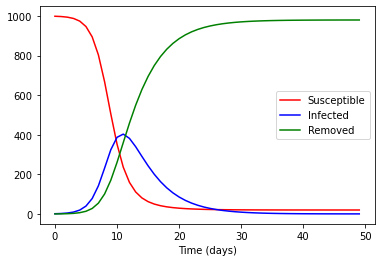

In [76]:
ret = odeint(sir_model, x0, t, args=(N, beta, gamma))   #inputs are model, initial conditions, time vector, then parameters
S, I, R = ret.T

f, ax = plt.subplots(1,1)
ax.plot(t, S, 'r', label = 'Susceptible')
ax.plot(t, I, 'b', label = 'Infected')
ax.plot(t, R, 'g', label = 'Removed')
ax.set_xlabel('Time (days)')
legend = ax.legend()
plt.show()

## Part 2: Stochastic SIR Model (Single Patch)
Now let's set up the stochastic version of the SIR model. This will be the code we will build from to explore multipatch models.

Stochastic models allow for infection to spread through the population even if $\mathcal{R}_0 < 1$ through random events. We will explore below a basic example of a single-patch stochastic model, and in the following section expand it into a multi-patch model.

Instead of $\beta$ and $\gamma$, we will now have $p_i$ the probability of infection and $p_r$ the probability of recovering once you are infected. We will define a new function called *update()* that will simulate one time step forward.

<div class="alert alert-block alert-info">
<b>Note:</b> To build towards our 2 patch model, we are going to now use <b>global</b> variables instead of inputting values into our functions.
</div>

In [77]:
def update():
    #Stochastic SIR Model
    
    ###########################
    #Input:
    #   Ss, Is, Rs          state variables Ss, Is, Rs
    #   p_i                 probability of infection 
    #   p_r                 probability of recovery 
    #
    #Output:
    #   Ss, Is, Rs          vectors of state variables through time
    ###########################
    global Ss, Is, Rs, p_i, p_r

    
    n = len(Is) - 1  #index of final value in our state variable vectors
    Ss.append(0)     #initialize empty new step
    Is.append(0)
    Rs.append(0)
    
    #Initialize our with values from previous step
    Ss[n+1] = Ss[n] 
    Is[n+1] = Is[n]
    Rs[n+1] = Rs[n]

    
    if Is[n] == 0:  #If there are no infected people, next time step cannot have infections
        Is[n+1] = 0
    else:          #Yes infection exists in this patch, so we need to calculate new infections and recovery
        for i in range(int(Ss[n])):
            if np.random.uniform(0,1) < p_i and Ss[n+1]> 0: #Susceptible person gets infected
                Ss[n+1] -= 1
                Is[n+1] += 1  
        for j in range(int(I[n])):
            if np.random.uniform(0,1) < p_r and Is[n+1] > 0: #Infected person recovers
                Is[n+1] -= 1
                Rs[n+1] += 1

Again, let's assume we have a total population of 1000 and we introduce 1 infected person into this population. We will run our model for 50 days as above, assuming that each step in our model is a single day. For this example, we will set $p_i = 0.1$ and $p_r = 0.2$.

R0 is 0.5


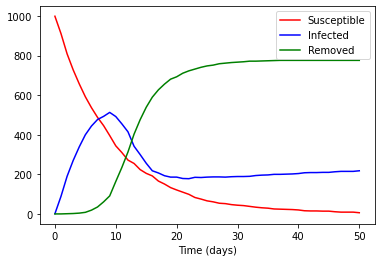

In [78]:
p_i = 0.1
p_r = 0.2

R0 = p_i / p_r
print('R0 is', R0)

Ss, Is, Rs = [999], [1], [0]     #initial conditions with 1 infected in completely susceptible population

t = np.linspace(0, 50, 51)       #Grid of time points (in days)
timesteps = 50                   #number of timesteps per simulation

for k in range(timesteps):
    update()

f, ax = plt.subplots(1,1)
ax.plot(t, Ss, 'r', label = 'Susceptible')
ax.plot(t, Is, 'b', label = 'Infected')
ax.plot(t, Rs, 'g', label = 'Removed')
ax.set_xlabel('Time (days)')
legend = ax.legend()
plt.show()

Since this code is stochastic, we should run the code multiple times and take the average as our answer. 

Let's write a function that will calculate and plot our confidence bands for us!

In [79]:
def plot_confidence(myarrays):
    #
    ###########################
    #Input:
    #   myarrays            list of Sarray, Iarray, Rarray
    #
    #Output:
    #   plot of S, I, R over time t with 95%, 75% confidence bands
    ###########################
    
    #Plot the results with a 95% confidence band
    mycolors = [['lightcoral','indianred','red'],['lightsteelblue', 'cornflowerblue','blue'],['lightgreen','limegreen','green']]
    mylabels = ['Susceptible', 'Infected', 'Removed']
    for kk in range(3):
        p = myarrays[kk]               #select the corrrect array
        colors = mycolors[kk]          #select the color palette list
    
        prev95 = np.quantile(p, 0.95, axis=1)
        prev75 = np.quantile(p, 0.75, axis=1)
        prev50 = np.quantile(p, 0.5, axis=1)
        prev25 = np.quantile(p, 0.25, axis=1)
        prev05 = np.quantile(p, 0.05, axis=1)
    
        plt.fill_between(range(timesteps), prev95, prev05, color = colors[0])   #95% confidence band
        plt.fill_between(range(timesteps), prev75, prev25, color = colors[1])   #75% confidence band
        plt.plot(range(timesteps), prev50, c = colors[2], label = mylabels[kk]) #Mean solution (50%)
        plt.xlabel("Time")
        plt.legend()
    plt.show()

We will run the model 100 times, find the average of the solutions, and plot our results.

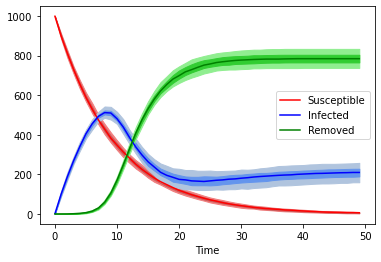

In [80]:
timesteps = 50        #number of timesteps per simulation
numsims = 100         #number of simulations to run

# These array will store the time series of Ss, Is, and Rs infected for each simulation
Sarray = np.zeros([timesteps,numsims]) 
Iarray = np.zeros([timesteps,numsims]) 
Rarray = np.zeros([timesteps,numsims]) 

for ii in range(numsims):            #loop over all simulations
    Ss, Is, Rs = [999], [1], [0]     #initial conditions with 1 infected in completely susceptible population
    
    for jj in range(1,timesteps):    #loop over the timesteps for the simulation
        update()
    Sarray[:,ii] = Ss                #store the results in the arrays
    Iarray[:,ii] = Is
    Rarray[:,ii] = Rs

#Plot the results with a 95% confidence band
myarrays = [Sarray, Iarray, Rarray]
plot_confidence(myarrays)
    


## Part 3: Stochastic SIR Model (Multi-Patch)
How can we now expand this model to include multiple patches? We are going to use a library called *networkx* for this section, and envision our two patches as nodes on a grid. Our new library of packages will be the following:

In [81]:
import numpy as np                  # useful array objects 
                                    # (also a core scientific computing library)
from math import *                  # useful math functions
import matplotlib.pyplot as plt     # nice plotting commands

#New packages
import networkx as nx               #network library where our grid structure will come from
import copy                         #for creating independent deep copies of objects (as opposed to shallow copies)

To begin with, we will write code for a 2-patch model. Instead of using a single line to initialize S, I, and R, we will write a function that will initialize these values *per patch* on our grid. 

First, let's learn how to use create a 2-node grid in networkx. We will explore some of the basic features of this program below:

In [96]:
g = nx.grid_2d_graph(1,2)              #Initialize grid "g" with two nodes
    
#Create a sub attribute for each node for Susceptible, infected, and removed
nx.set_node_attributes(g, 0, 'sus')    
nx.set_node_attributes(g, 0, 'inf') 
nx.set_node_attributes(g, 0, 'rem') 
nx.set_node_attributes(g, 0, 'total population') #We can also track the total population in each cell
    
# Assign population to each node. For now they will be the same
for (u,v) in gtest.nodes(data=True):
    mynum =  500                   #np.random.normal(100,10)
    v['total population'] = mynum
    v['sus'] = mynum
    
# Debug
print(nx.info(g))
nodeDict = dict(g.nodes(data=True))
print(nodeDict)

Name: 
Type: Graph
Number of nodes: 2
Number of edges: 1
Average degree:   1.0000
{(0, 0): {'sus': 0, 'inf': 0, 'rem': 0, 'total population': 0}, (0, 1): {'sus': 0, 'inf': 0, 'rem': 0, 'total population': 0}}


<div class="alert alert-block alert-warning">
<b>Bonus:</b> How can we change the code above to allow for inhomogeneous populations? How can we generalize the code above to allow for any sized grid? What other features might we want to track in our patches?
</div>


Ok! Now let's take all of these ideas and put it into a function called *initialize()* that will generate our initial patches. Instead of tracking susceptible, infected, and removed, we will now track the prevalence of disease on the whole network in an object called *prev*.

Prevalence is the number of total infected cases at time *t* divided by the total population at risk. We assume that all people in our patches are at risk due to a small population and homogeneous mixing.

In [97]:
def initialize():
    #Initialize the grid
    
    ###########################
    #Input:
    #   N           number of rows in grid  (****remove for sandbox version of code****)
    #   M           number of columns in grid (****remove for sandbox version of code****)
    #
    #Output:
    #   g           grid with population per cell and sus/inf/rec per cell
    #   nextg       copy of g
    #   mynode      coordinates of initial node infected
    #   initload    initial number of people infected
    #   Sarray, Iarray, Rarray        Ss, Is, Rs trackers
    ###########################
    global g, nextg, mynode, initload, Ss, Is, Rs
    
    g = nx.grid_2d_graph(1,2)              #Initialize grid "g" with two nodes
    
    #Create a sub attribute for each node for Susceptible, infected, and removed
    nx.set_node_attributes(g, 0, 'sus')    
    nx.set_node_attributes(g, 0, 'inf') 
    nx.set_node_attributes(g, 0, 'rem') 
    nx.set_node_attributes(g, 0, 'total population') #We can also track the total population in each cell
    
    # Assign population to each node. For now they will be the same
    for (u,v) in g.nodes(data=True):
        mynum =  500 
        v['total population'] = mynum
        v['sus'] = mynum
    
    # Infect one node
    mynode = 1                             #(round((N-1)/2), round((M-1)/2))
    initload = 1                           #np.random.uniform(1,10) 
    g._node[0,mynode]['inf'] = initload
    g._node[0,mynode]['sus'] -= initload
    
    # Initialize nextg
    nextg = g.copy()                             #create a deep copy of our patches; this will be used in update()
    pos = {(x,y):(y,-x) for x,y in g.nodes()}
    g.pos = pos
    nextg.pos = pos
    
    Ss.append(sum([g._node[n]['sus'] for n in g]))  
    Is.append(sum([g._node[n]['inf'] for n in g])) 
    Rs.append(sum([g._node[n]['rem'] for n in g])) 
    
  

<div class="alert alert-block alert-warning">
<b>Bonus:</b> How can we initialize on the center cell of a generalized grid? What happens if we randomize the initial load? Initialize infection in multiple nodes?
</div>

We need to change our update step to account for our new grid setting! 

In [98]:
def update2():
    #Update the infection grid one time step
    
    ###########################
    #Input:
    #   g       grid with population per cell and sus/inf/rec per cell
    #   nextg   grid with pop per cell to update during this function step
    #   prev    prevalence tracker
    #
    #Output:
    #   g       g grid updated one time step
    #   prev    prevalence tracker
    ###########################
    global g, nextg, Ss, Is, Rs
    
    nextg = g.copy()
    nextg.pos = g.pos
    
    for a in g._node:
        if g._node[a]['inf'] == 0:                            #NO infections in current node
            nextg._node[a]['inf'] = 0
            for b in g.neighbors(a):
                if g._node[b]['inf'] > 0 :                    #Then neighbors in node b can infect current node a
                    #loop over all susceptible people in node a
                    for i in range(int(g._node[a]['sus'])):                        
                        if np.random.uniform(0,1) < p_i and nextg._node[a]['sus'] > 0:
                            nextg._node[a]['sus'] -= 1
                            nextg._node[a]['inf'] += 1
        else:                                                 #YES infection exists in current node a
            #loop over all neighbors
            for b in g.neighbors(a):                          #Then infection can spread to neighboring cells
                #loop over all susceptibles in neighbor node b
                for j in range(int(g._node[b]['sus'])):
                    if np.random.uniform(0,1) < p_i:
                        nextg._node[b]['sus'] -= 1
                        nextg._node[b]['inf'] += 1 
                    
                                                              #And probability that infected in node a can recover
            for i in range(nextg._node[a]['inf']):
                if np.random.uniform(0,1) < p_r:
                    nextg._node[a]['inf'] -= 1
                    nextg._node[a]['rem'] += 1
           
    #Overwrite original network with new network
    g = nextg.copy()
    g.pos = nextg.pos   

    #Store the new Ss, Is, Rs
    Ss.append(sum([g._node[n]['sus'] for n in g]))  
    Is.append(sum([g._node[n]['inf'] for n in g])) 
    Rs.append(sum([g._node[n]['rem'] for n in g])) 


Now we can run our 2-patch model with the same parameters as the 1-patch model and see how our results change!

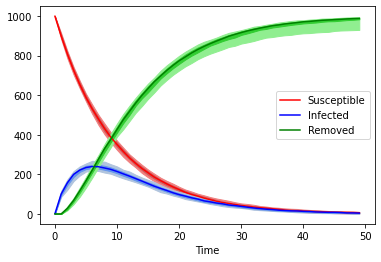

In [99]:
# These array will store the time series of Ss, Is, and Rs infected for each simulation
Sarray = np.zeros([timesteps,numsims]) 
Iarray = np.zeros([timesteps,numsims]) 
Rarray = np.zeros([timesteps,numsims])

for ii in range(numsims):         #loop over all simulations
    Ss = []                       #initialize susceptible, infected, removed arrays
    Is = []
    Rs = []
    
    initialize()                  #initialize grid
    
    for jj in range(1,timesteps): #loop over the timesteps
        update2()
    Sarray[:,ii] = Ss             #store the resulting simulation in arrays
    Iarray[:,ii] = Is
    Rarray[:,ii] = Rs

    
#Plot the results with a 95% confidence band
myarrays = [Sarray, Iarray, Rarray]
plot_confidence(myarrays)

Wow! Our results have changed just from dividing the population into two interacting patches! Play around with the code and see what different results you can generate by:
* Adding more patches
* Giving each patch a unique population
* Assigning each patch a unique probability of recovery (p_r, simulates access to healthcare)
* Assigning each patch a unique probability of infection (p_i, simulates compliance to health regulations)
* Plotting the S, I, R timelines for each patch separately
* Change the probability of infection per node



<div class="alert alert-block alert-info">
<b>Note:</b> This code was designed to be used to PyCX Simulator if you want to watch how the network evolves over time. PyCX Simulator also needs a function called *observe()* which is shown here.
    
    ```python
    import pycxsimulator as pycx
    
    def observe():
        #Print the current infection status of the grid
    
        ###########################
        #Input:
        #   g       grid with population per cell and sus/inf/rec per cell
        #   prev    prevalence tracker
        #
        #Output:
        #   plot of infection spread on grid
        ###########################
    
        global g, prev
        cla()
        nx.draw(g, cmap = cm.Wistia, vmin = 0, vmax = max([g._node[n]['total population'] for n in g]),
                node_color = [g._node[i]['inf'] for i in g.nodes],
                pos = g.pos)
    
    #Run the GUI; ***this code does not work in the Jupyter environment***
    pycx.GUI().start(func=[initialize, observe, update])
    ```
</div>

Currently, with our 2-patches, the visualization is not very interesting. But if we add more nodes, the network below will begin to give us an idea for how disease is flowing through our network or through patches in the network.

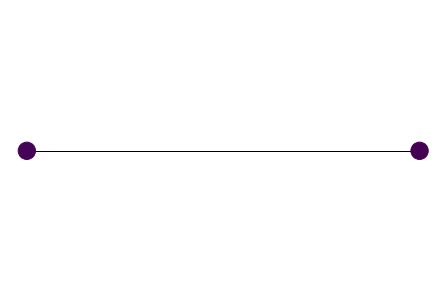

In [101]:
nx.draw(g, vmin = 0, vmax = max([g._node[n]['total population'] for n in g]),
            node_color = [g._node[i]['inf'] for i in g.nodes],
            pos = g.pos)